# English Wikipedia page views, 2008 - 2017

For this assignment, your job is to analyze traffic on English Wikipedia over time, and then document your process and the resulting dataset and visualization according to best practices for open research that were outlined for you in class.

## Setup

In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

%matplotlib inline

headers={'User-Agent' : 'https://github.com/rexthompson', 'From' : 'rext@uw.edu'}

## Data Ingest

In [2]:
# create a dictionary to hold API response data
data_dict = dict()

Note that the [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) has slightly different schema than the [pageview API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) shown here.

### Pagecounts (Legacy data)

In [6]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
access_sites = ['desktop-site', 'mobile-site']

for access_site in access_sites:
    
    # set filename for access-specific API call response JSON file
    filename = 'data/raw/pagecounts_' + access_site + '_200807_201709.json'
    
    # check if file already exists; load if so, create if not
    if os.path.isfile(filename):
        with open(filename) as json_data:
            response = json.load(json_data)
        print('loaded JSON data from ./' + filename)
    else:
        # define parameters
        params = {'project' : 'en.wikipedia.org',
                  'access-site' : access_site,     # [all-sites, desktop-site, mobile-site]
                  'granularity' : 'monthly',       # [hourly, daily, monthly]
                  'start' : '2008010100',
                  'end' : '2017100100' # use the first day of the following month to ensure a full month of data is collected
                  }
        
        # fetch and format data
        api_call = requests.get(endpoint.format(**params), headers)
        response = api_call.json()
        
        # format and save output as JSON file
        with open(filename, 'w') as f:
             json.dump(response, f)
        print('saved JSON data to ./' + filename)
    
    # convert to dataframe
    temp_df = pd.DataFrame.from_dict(response['items'])
    temp_df['yyyymm'] = temp_df.timestamp.str[0:6]
    col_name = 'pc_' + access_site
    temp_df.rename(columns={'count': col_name}, inplace=True)
        
    # save to dictionary for later combination
    data_dict[col_name] = temp_df[['yyyymm', col_name]]

saved JSON data to ./data/raw/pagecounts_desktop-site_200807_201709.json
saved JSON data to ./data/raw/pagecounts_mobile-site_200807_201709.json


### Pageviews (New data)

In [7]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
access_sites = ['desktop', 'mobile-app', 'mobile-web']

for access_site in access_sites:
    
    # set filename for access-specific API call response JSON file
    filename = 'data/raw/pageviews_' + access_site  + '_200807_201709.json'

    # check if file already exists; load if so, create if not
    if os.path.isfile(filename):
        with open(filename) as f:
            response = json.load(f)
        print('loaded JSON data from ./' + filename)
    else:
        # define parameters
        params = {'project' : 'en.wikipedia.org',
                  'access' : access_site,         # [all-access, desktop, mobile-app, mobile-web]
                  'agent' : 'user',               # [all-agents, user, spider]
                  'granularity' : 'monthly',      # [hourly, daily, monthly]
                  'start' : '2008010100',
                  'end' : '2017100100' # use the first day of the following month to ensure a full month of data is collected
                  }

        # fetch and format data
        api_call = requests.get(endpoint.format(**params), headers)
        response = api_call.json()

        # format and save output as JSON file
        with open(filename, 'w') as f:
             json.dump(response, f)
        print('saved JSON data to ./' + filename)

    # convert to dataframe
    temp_df = pd.DataFrame.from_dict(response['items'])
    temp_df['yyyymm'] = temp_df.timestamp.str[0:6]
    col_name = 'pv_' + access_site
    temp_df.rename(columns={'views': col_name}, inplace=True)
        
    # save to dictionary for later combination
    data_dict[col_name] = temp_df[['yyyymm', col_name]]

saved JSON data to ./data/raw/pageviews_desktop_200807_201709.json
saved JSON data to ./data/raw/pageviews_mobile-app_200807_201709.json
saved JSON data to ./data/raw/pageviews_mobile-web_200807_201709.json


## Data Aggregation and Cleanup

At this point our data consists of five separate dataframes, stored in a single data dictionary. We want to get this all into the same dataframe so we can work with it, export it, and plot it.

In [12]:
keys = list(data_dict.keys())

df = data_dict[keys[0]]
for i in range(1, len(keys)):
    df = df.merge(data_dict[keys[i]], how='outer', on='yyyymm')

Replace NaN values with zero and convert floats to integers.

In [13]:
df = df.fillna(0)
df.iloc[:,1:] = df.iloc[:,1:].astype(int)

Create the final dataframe that we'll export to CSV. This is the data we'll plot too.

In [14]:
df_new = pd.DataFrame({'year':df['yyyymm'].str[0:4],
                       'month':df['yyyymm'].str[4:6],
                       'pagecount_all_views':df['pc_desktop-site'] + df['pc_mobile-site'],
                       'pagecount_desktop_views':df['pc_desktop-site'].astype(int),
                       'pagecount_mobile_views':df['pc_mobile-site'],
                       'pageview_all_views':df['pv_desktop'] + df['pv_mobile-app'] + df['pv_mobile-web'],
                       'pageview_desktop_views':df['pv_desktop'],
                       'pageview_mobile_views':df['pv_mobile-app'] + df['pv_mobile-web']})

# reorder columns
df_new = df_new[['year',
                 'month',
                 'pagecount_all_views',
                 'pagecount_desktop_views',
                 'pagecount_mobile_views',
                 'pageview_all_views',
                 'pageview_desktop_views',
                 'pageview_mobile_views']]

Now we'll save to CSV, unless the file already exists in which case we can load for utmost transparency. We'll call this data "prelim" since we aren't sure yet if there are any problems with the data.

In [15]:
# set filename for combined data CSV
filename = 'data/en-wikipedia_traffic_200801-201709_prelim.csv'

# check if file already exists; load if so, create if not
if os.path.isfile(filename):
    df_new = pd.read_csv(filename)
    print('loaded CSV data from ./' + filename)
else:
    df_new.to_csv(filename, index=False, )
    print('saved CSV data to ./' + filename)

saved CSV data to ./data/en-wikipedia_traffic_200801-201709_prelim.csv


## Data Visualization

In [16]:
df_new.replace(0, float('nan'), inplace=True)

In [17]:
yyyymm = pd.to_datetime(df_new['year'].astype(str) + df_new['month'].astype(str), format='%Y%m')

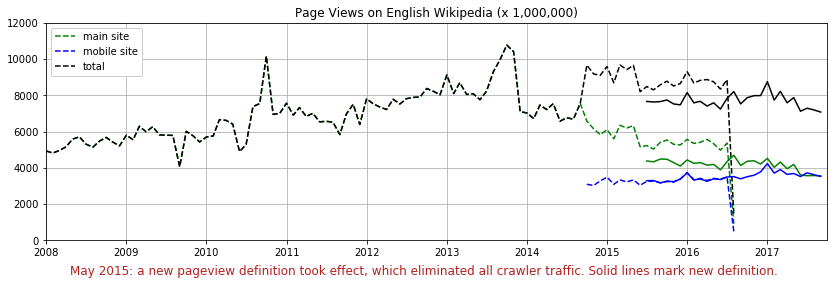

In [18]:
plt.rcParams["figure.figsize"] = (14, 4)
plt.plot(yyyymm, df_new['pagecount_desktop_views']/1e6, 'g--')
plt.plot(yyyymm, df_new['pagecount_mobile_views']/1e6, 'b--')
plt.plot(yyyymm, df_new['pagecount_all_views']/1e6, 'k--')
plt.legend(['main site','mobile site','total'], loc=2, framealpha=1)
plt.plot(yyyymm, df_new['pageview_desktop_views']/1e6, 'g-')
plt.plot(yyyymm, df_new['pageview_mobile_views']/1e6, 'b-')
plt.plot(yyyymm, df_new['pageview_all_views']/1e6, 'k-')
plt.grid(True)
plt.ylim((0,12000))
plt.xlim(('2008-01-01','2017-10-01'))
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.suptitle('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.', y=0.04, color='#b22222');

We notice in the plot above that there appears to be some bad data in mid-2016. Let's see if we can figure out what's going on here.

In [19]:
df_new.loc[(pd.DatetimeIndex(yyyymm).year == 2016)]

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
96,2016,01,9.309261e+09,5.569633e+09,3.739629e+09,8.154016e+09,4.436179e+09,3.717837e+09
97,2016,02,8.680941e+09,5.347709e+09,3.333231e+09,7.585859e+09,4.250997e+09,3.334862e+09
98,2016,03,8.827530e+09,5.407676e+09,3.419854e+09,7.673275e+09,4.286590e+09,3.386684e+09
99,2016,04,8.873621e+09,5.572235e+09,3.301385e+09,7.408148e+09,4.149384e+09,3.258764e+09
100,2016,05,8.748968e+09,5.330532e+09,3.418436e+09,7.586811e+09,4.191778e+09,3.395033e+09
101,2016,06,8.347711e+09,4.975092e+09,3.372618e+09,7.243631e+09,3.888840e+09,3.354791e+09
102,2016,07,8.864628e+09,5.363966e+09,3.500661e+09,7.834440e+09,4.337866e+09,3.496574e+09
103,2016,08,1.393717e+09,9.136759e+08,4.800413e+08,8.210866e+09,4.695046e+09,3.515819e+09
104,2016,09,NaN,NaN,NaN,7.528292e+09,4.135006e+09,3.393286e+09
105,2016,10,NaN,NaN,NaN,7.871022e+09,4.361738e+09,3.509284e+09


It looks like row 103 has lower values for the first three columns. Let's kill these.

In [20]:
# update values
df_new.loc[103,['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views']] = None

Let's plot again to see how it looks.

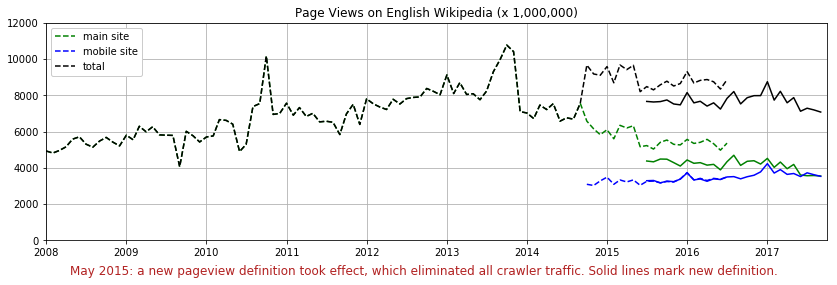

In [21]:
plt.rcParams["figure.figsize"] = (14, 4)
plt.plot(yyyymm, df_new['pagecount_desktop_views']/1e6, 'g--')
plt.plot(yyyymm, df_new['pagecount_mobile_views']/1e6, 'b--')
plt.plot(yyyymm, df_new['pagecount_all_views']/1e6, 'k--')
plt.legend(['main site','mobile site','total'], loc=2, framealpha=1)
plt.plot(yyyymm, df_new['pageview_desktop_views']/1e6, 'g-')
plt.plot(yyyymm, df_new['pageview_mobile_views']/1e6, 'b-')
plt.plot(yyyymm, df_new['pageview_all_views']/1e6, 'k-')
plt.grid(True)
plt.ylim((0,12000))
plt.xlim(('2008-01-01','2017-10-01'))
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.suptitle('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.', y=0.04, color='#b22222')
plt.savefig('en-wikipedia_traffic_200801-201709.png', dpi=80);

That looks better!!

Now let's output the final data file which was used to make this visualization.

In [22]:
# data formatting updates
df_new = df_new.fillna(0)
df_new.iloc[:,1:] = df_new.iloc[:,1:].astype(int)

# set filename for combined data CSV
filename = 'data/en-wikipedia_traffic_200801-201709.csv'

# check if file already exists; load if so, create if not
if os.path.isfile(filename):
    df_new = pd.read_csv(filename)
    print('loaded CSV data from ./' + filename)
else:
    df_new.to_csv(filename, index=False, )
    print('saved CSV data to ./' + filename)

saved CSV data to ./data/en-wikipedia_traffic_200801-201709.csv


## Analysis

This completes our analysis.